# Credit Card Transactions Fraud Detection

## **Part IV:** Fine Tuning
**Table of contents:**

1. Hyperparameter tuning on the best performing models from Part 3 (XGBoost)
2. Try the above best fine-tuned model on the subset **of 13 features (excluse 'city')**
3. Threshold Adjustment
4. Save the best model
5. Save the best model after adjusting the threshold

## Import libraries

In [24]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
# Load data
X_train = pd.read_csv('../data/X_train_full_features.csv')  
X_test = pd.read_csv('../data/X_test_full_features.csv')    
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [3]:
# Check shape
X_train.shape, y_train.shape,  X_test.shape,  y_test.shape

((2062670, 14), (2062670, 1), (259335, 14), (259335, 1))

# 1. Hyperparameter tuning on the best performing models from Part 3

## XGBoost

## 1st

In [4]:
# Define the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Define the scorer
scorer = make_scorer(precision_score)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=scorer, cv=5, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best precision score on training set: {grid_search.best_score_}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
Best precision score: 0.9995286347739369


In [25]:
# Predict using the best model
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)     # Predict on training data
y_train_pred = best_model.predict(X_train)   # Predict on testing data

print(f"Precision score on testing set: {precision_score(y_test, y_test_pred)}")
print(f"Precision score on training set: {precision_score(y_train, y_train_pred)}")

Precision score on testing set: 0.9256661991584852
Precision score on training set: 0.9997264823299826


In [15]:
# Evaluation Metrics for Training Set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print("\nTraining Metrics:")
print(f"  Accuracy: {train_accuracy}")
print(f"  Precision: {train_precision}")
print(f"  Recall: {train_recall}")
print(f"  F1 Score: {train_f1}")

# Evaluation Metrics for Testing Set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nTesting Metrics:")
print(f"  Accuracy: {test_accuracy}")
print(f"  Precision: {test_precision}")
print(f"  Recall: {test_recall}")
print(f"  F1 Score: {test_f1}")

# Confusion Matrix for Testing Set
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

# Classification Report for Testing Set
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Training Metrics:
  Accuracy: 0.9995699748384376
  Precision: 0.9997264823299826
  Recall: 0.9994133816849036
  F1 Score: 0.999569907488895

Testing Metrics:
  Accuracy: 0.9988933233076909
  Precision: 0.9256661991584852
  Recall: 0.8794137241838774
  F1 Score: 0.9019473864024599

Confusion Matrix:
[[257728    106]
 [   181   1320]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.93      0.88      0.90      1501

    accuracy                           1.00    259335
   macro avg       0.96      0.94      0.95    259335
weighted avg       1.00      1.00      1.00    259335



#### Visualization

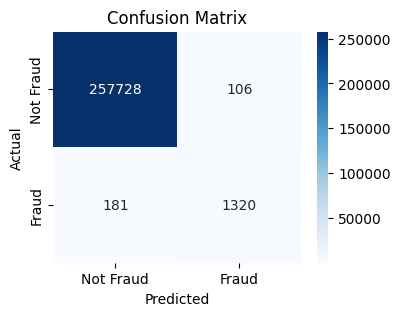

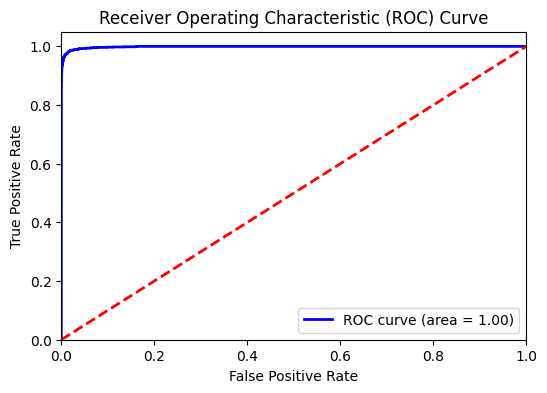

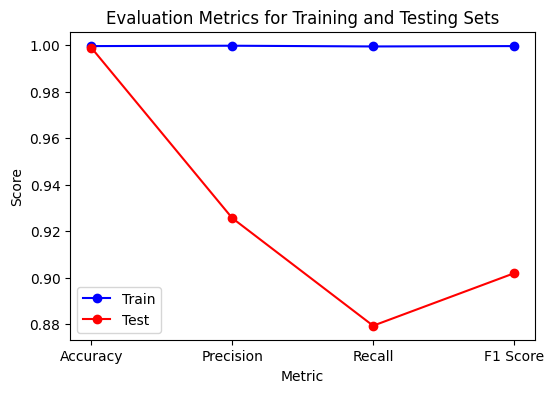

In [18]:
# 1.Plotting Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 2.Plotting ROC Curve
y_test_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 3.Plotting Precision Score
scores = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = range(len(scores))

plt.figure(figsize=(6, 4))
plt.plot(x, train_scores, marker='o', linestyle='-', color='b', label='Train')
plt.plot(x, test_scores, marker='o', linestyle='-', color='r', label='Test')
plt.xticks(x, scores)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Evaluation Metrics for Training and Testing Sets')
plt.legend()
plt.show()

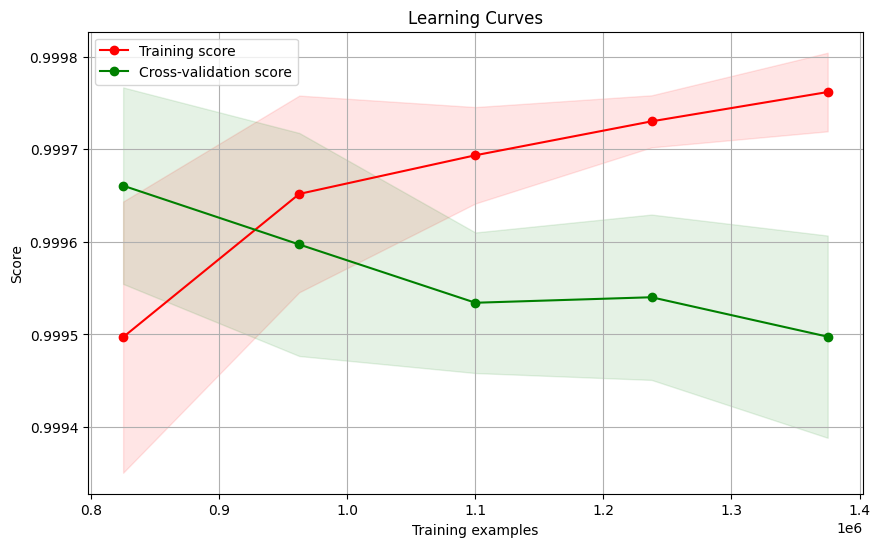

In [23]:

# Function to plot learning curve
def plot_learning_curve(estimator, X, y, cv, scoring):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Learning Curves")
    plt.grid()
    plt.show()

# Plot learning curve for XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **grid_search.best_params_)
plot_learning_curve(xgb, X_train, y_train, cv=5, scoring='precision')

Observing Overfitting:

If the training score is significantly higher than the validation score and the validation score does not improve with more data, it indicates overfitting.
By plotting the learning curves, we can observe how well our model generalizes to unseen data and whether it is overfitting or underfitting.

## 2nd: **Further Fine-tuning** Hyperparameters with a Narrower Range

In [26]:
# Define the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the refined hyperparameter grid
param_grid = {
    'n_estimators': [140, 150, 160],
    'max_depth': [6, 7, 8, 9, 10],
    'learning_rate': [0.15, 0.2, 0.25],
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.85, 0.9, 0.95],
    'scale_pos_weight': [1, 10, 25, 50]
}

# Define the scorer
scorer = make_scorer(precision_score)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=scorer, cv=5, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best precision score on training set: {grid_search.best_score_}")

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
Best parameters: {'colsample_bytree': 0.95, 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 160, 'scale_pos_weight': 1, 'subsample': 0.85}
Best precision score on training set: 0.9997614572105356


In [27]:
# Predict using the best model
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)     # Predict on training data
y_train_pred = best_model.predict(X_train)   # Predict on testing data

print(f"Precision score on testing set: {precision_score(y_test, y_test_pred)}")
print(f"Precision score on training set: {precision_score(y_train, y_train_pred)}")

Precision score on testing set: 0.9652425778421434
Precision score on training set: 1.0


Note: This run 12 hours.

> Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
>
> Best parameters: **{'colsample_bytree': 0.95, 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 160, 'scale_pos_weight': 1, 'subsample': 0.85}**
>
> Precision score on training set: 0.9997614572105356
> 
> Precision score on testing set: 0.9652425778421434

In [28]:
# Evaluation Metrics for Training Set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print("\nTraining Metrics:")
print(f"  Accuracy: {train_accuracy}")
print(f"  Precision: {train_precision}")
print(f"  Recall: {train_recall}")
print(f"  F1 Score: {train_f1}")

# Evaluation Metrics for Testing Set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nTesting Metrics:")
print(f"  Accuracy: {test_accuracy}")
print(f"  Precision: {test_precision}")
print(f"  Recall: {test_recall}")
print(f"  F1 Score: {test_f1}")

# Confusion Matrix for Testing Set
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

# Classification Report for Testing Set
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Training Metrics:
  Accuracy: 1.0
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0

Testing Metrics:
  Accuracy: 0.999167100468506
  Precision: 0.9652425778421434
  Recall: 0.8880746169220519
  F1 Score: 0.9250520471894518

Confusion Matrix:
[[257786     48]
 [   168   1333]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.97      0.89      0.93      1501

    accuracy                           1.00    259335
   macro avg       0.98      0.94      0.96    259335
weighted avg       1.00      1.00      1.00    259335



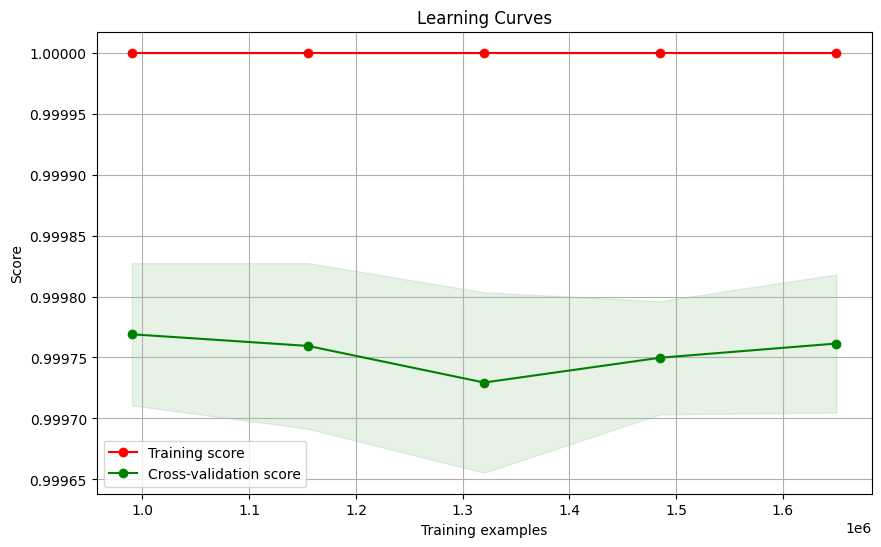

In [29]:
# Plot learning curve for XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **grid_search.best_params_)
plot_learning_curve(xgb, X_train, y_train, cv=5, scoring='precision')

### **Comment**:
>With the above parameters of this 2nd time tuning, the **better precision result** are achieved as follows:
>- Best parameters: **{'colsample_bytree': 0.95, 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 160, 'scale_pos_weight': 1, 'subsample': 0.85}**
>- Best precision score on training set: 0.9998
>- Precision score on testing set: **0.9652**

>Compared to the result of 1st time as follows:
>- Best parameters: **{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}**
>- Precision score on training set: 0.9997
>- Precision score on testing set: **0.9256**

**Now we continue to further fine tuning (3rd time)** to achieve better precision score on testing test. Based on the above information, now we "Define the refined hyperparameter grid" to increase efficiency:

- Narrow down the search range around previously found optimal values.
- Experiment with additional values of `scale_pos_weight`.
- Add or tweak values of other parameters such as `min_child_weight` and `gamma`.

## 3rd: **Continuing Further Fine-tuning** Hyperparameters with a Narrower Range

In [31]:
# Define the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the refined hyperparameter grid
param_grid = {
    'n_estimators': [160, 170, 180],
    'max_depth': [10, 11, 12],
    'learning_rate': [0.25, 0.3],
    'subsample': [0.85, 0.9, 0.95],
    'colsample_bytree': [0.95, 1.0],
    'scale_pos_weight': [1, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3]
}


# Define the scorer
scorer = make_scorer(precision_score)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=scorer, cv=5, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best precision score on training set: {grid_search.best_score_}")

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
Best parameters: {'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.25, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 180, 'scale_pos_weight': 1, 'subsample': 0.85}
Best precision score on training set: 0.9997672829335981


In [32]:
# Predict using the best model
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)     # Predict on training data
y_train_pred = best_model.predict(X_train)   # Predict on testing data

print(f"Precision score on testing set: {precision_score(y_test, y_test_pred)}")
print(f"Precision score on training set: {precision_score(y_train, y_train_pred)}")

Precision score on testing set: 0.9680232558139535
Precision score on training set: 1.0


Note: This run 24 hours.

> Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
> 
> Best parameters: **{'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.25, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 180, 'scale_pos_weight': 1, 'subsample': 0.85}**
>
> Precision score on training set: 0.9997672829335981
> 
> Precision score on testing set: 0.9680232558139535

### **Comment**:
>With the above parameters of this 3rd time tuning, the the pretty same **precision result** are achieved as follows:
>- Best parameters: **{'colsample_bytree': 0.95, 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 180, 'scale_pos_weight': 1, 'subsample': 0.85, 'gamma': 0, 'min_child_weight': 1}**
>- Best precision score on training set: 0.9998
>- Precision score on testing set: **0.9680**

>Compared to the result of 2nd time as follows:
>- Best parameters: **{'colsample_bytree': 0.95, 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 160, 'scale_pos_weight': 1, 'subsample': 0.85}**
>- Best precision score on training set: 0.9998
>- Precision score on testing set: **0.9652**

**Now we continue to further fine tuning (4rd time)** to achieve better precision score on testing test. Based on the above information, now we "Define the refined hyperparameter grid" to increase efficiency:

- Narrow down the search range around previously found optimal values.
- Experiment with increased values of `n_estimators`.

## 4th: **Continuing Further Fine-tuning** Hyperparameters with a Narrower Range

In [33]:
# Define the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the refined hyperparameter grid
param_grid = {
    'n_estimators': [160, 180, 200, 250, 300, 400],
    'max_depth': [10],
    'learning_rate': [0.25, 0.3],
    'subsample': [0.85],
    'colsample_bytree': [0.95],
    'scale_pos_weight': [1],
    'min_child_weight': [1],
    'gamma': [0]
}


# Define the scorer
scorer = make_scorer(precision_score)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=scorer, cv=5, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best precision score on training set: {grid_search.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 400, 'scale_pos_weight': 1, 'subsample': 0.85}
Best precision score on training set: 0.9997837724068841


In [34]:
# Predict using the best model
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)     # Predict on training data
y_train_pred = best_model.predict(X_train)   # Predict on testing data

print(f"Precision score on testing set: {precision_score(y_test, y_test_pred)}")
print(f"Precision score on training set: {precision_score(y_train, y_train_pred)}")

Precision score on testing set: 0.9702683103698332
Precision score on training set: 1.0


Note: This run 10 minutes.

> Fitting 5 folds for each of 12 candidates, totalling 60 fits
>
> Best parameters: **{'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 400, 'scale_pos_weight': 1, 'subsample': 0.85}**
>
> Precision score on training set: 0.9997837724068841
> 
> Precision score on testing set: 0.9702683103698332

### **Comment**:
Apparently, we got better Precision score on testing set when increasing `n_estimators`.

Try more increasing `n_estimators`.

## 5th: **Continuing Further Fine-tuning** Hyperparameters with a Narrower Range

In [35]:
# Define the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the refined hyperparameter grid
param_grid = {
    'n_estimators': [400, 500, 600, 700, 800, 900, 1000],
    'max_depth': [10, 20],
    'learning_rate': [0,1, 0.25, 0.3, 0.35, 0.4],
    'subsample': [0.85],
    'colsample_bytree': [0.95],
    'scale_pos_weight': [1],
    'min_child_weight': [1],
    'gamma': [0]
}


# Define the scorer
scorer = make_scorer(precision_score)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=scorer, cv=5, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best precision score on training set: {grid_search.best_score_}")

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best parameters: {'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.25, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1000, 'scale_pos_weight': 1, 'subsample': 0.85}
Best precision score on training set: 0.9998002660697969


In [36]:
# Predict using the best model
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)     # Predict on training data
y_train_pred = best_model.predict(X_train)   # Predict on testing data

print(f"Precision score on testing set: {precision_score(y_test, y_test_pred)}")
print(f"Precision score on training set: {precision_score(y_train, y_train_pred)}")

Precision score on testing set: 0.9718004338394793
Precision score on training set: 1.0


Note: This run 3 hours.

> Fitting 5 folds for each of 84 candidates, totalling 420 fits
>
> Best parameters: **{'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1000, 'scale_pos_weight': 1, 'subsample': 0.85}**
>
> Precision score on training set: 0.9998002660697969
> 
> Precision score on testing set: 0.9718004338394793

### **Comment**:
When increasing `n_estimators` from 400 to 1000, we got better Precision score on testing set.

Try more increasing `n_estimators`.

## 6th: **Continuing Further Fine-tuning** Hyperparameters with a Narrower Range

In [37]:
# Define the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the refined hyperparameter grid
param_grid = {
    'n_estimators': [1000, 1200, 1500, 2000, 2500, 3000],
    'max_depth': [10, 20],
    'learning_rate': [0,1, 0.25, 0.3],
    'subsample': [0.85],
    'colsample_bytree': [0.95],
    'scale_pos_weight': [1],
    'min_child_weight': [1],
    'gamma': [0]
}


# Define the scorer
scorer = make_scorer(precision_score)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=scorer, cv=5, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best precision score on training set: {grid_search.best_score_}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.25, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 3000, 'scale_pos_weight': 1, 'subsample': 0.85}
Best precision score on training set: 0.9998022049954726


In [38]:
# Predict using the best model
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)     # Predict on training data
y_train_pred = best_model.predict(X_train)   # Predict on testing data

print(f"Precision score on testing set: {precision_score(y_test, y_test_pred)}")
print(f"Precision score on training set: {precision_score(y_train, y_train_pred)}")

Precision score on testing set: 0.9739696312364425
Precision score on training set: 1.0


Note: This run 3 hours.

> Fitting 5 folds for each of 84 candidates, totalling 420 fits
>
> Previous Best parameters: **{'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1000, 'scale_pos_weight': 1, 'subsample': 0.85}**
> 
>Now Best parameters: **{'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.25, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 3000, 'scale_pos_weight': 1, 'subsample': 0.85}**
>
> Precision score on training set: 0.9998022049954726
> 
> Precision score on testing set: 0.9739696312364425

### **Comment**:
Precision score on testing set did not improve much when increasing `n_estimators`.
It seems like that it reaches convergence.

In [39]:
# Evaluation Metrics for Training Set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print("\nTraining Metrics:")
print(f"  Accuracy: {train_accuracy}")
print(f"  Precision: {train_precision}")
print(f"  Recall: {train_recall}")
print(f"  F1 Score: {train_f1}")

# Evaluation Metrics for Testing Set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nTesting Metrics:")
print(f"  Accuracy: {test_accuracy}")
print(f"  Precision: {test_precision}")
print(f"  Recall: {test_recall}")
print(f"  F1 Score: {test_f1}")

# Confusion Matrix for Testing Set
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

# Classification Report for Testing Set
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Training Metrics:
  Accuracy: 1.0
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0

Testing Metrics:
  Accuracy: 0.9992673568935933
  Precision: 0.9739696312364425
  Recall: 0.8974017321785477
  F1 Score: 0.934119278779473

Confusion Matrix:
[[257798     36]
 [   154   1347]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.97      0.90      0.93      1501

    accuracy                           1.00    259335
   macro avg       0.99      0.95      0.97    259335
weighted avg       1.00      1.00      1.00    259335



#### Visualization

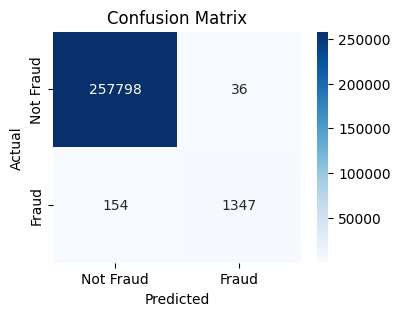

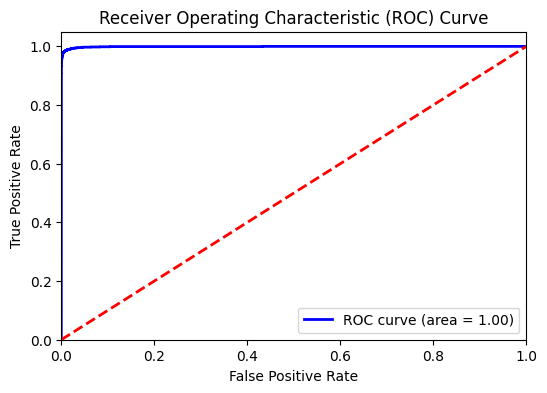

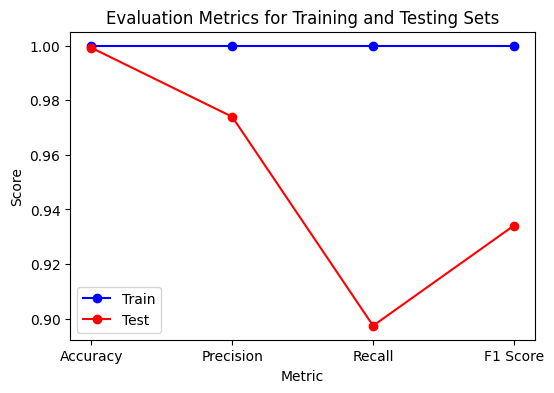

In [41]:
# 1.Plotting Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 2.Plotting ROC Curve
y_test_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 3.Plotting Precision Score
scores = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = range(len(scores))

plt.figure(figsize=(6, 4))
plt.plot(x, train_scores, marker='o', linestyle='-', color='b', label='Train')
plt.plot(x, test_scores, marker='o', linestyle='-', color='r', label='Test')
plt.xticks(x, scores)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Evaluation Metrics for Training and Testing Sets')
plt.legend()
plt.show()

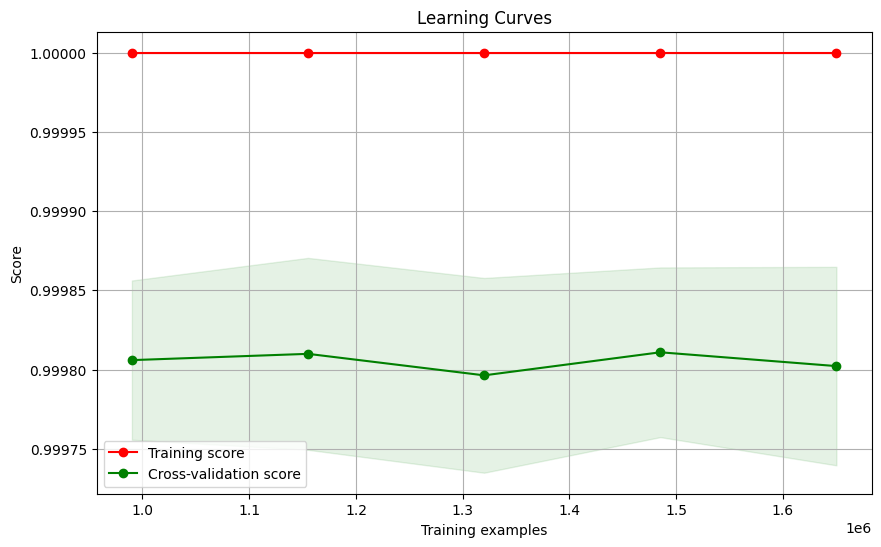

In [40]:
# Plot learning curve for XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **grid_search.best_params_)
plot_learning_curve(xgb, X_train, y_train, cv=5, scoring='precision')

# 2. Try the above best fine-tuned model on the subset **of 13 features (excluse 'city')**

In [42]:
# Try subset of 13 features (exclude 'city') **instead of full set of 14 features**

features = ['num__amt', 'num__city_pop', 'num__transaction_hour',
       'num__transaction_day_of_week', 'num__transaction_day_of_month',
       'num__transaction_month', 'num__age', 'num__distance', 'cat__category',
       'cat__gender', 'cat__state', 'cat__zip', 'cat__job']
X_train_subset = X_train[features]
X_test_subset = X_test[features]

In [43]:
# Define classifier with above best parameters
best_params = {
    'colsample_bytree': 0.95,
    'gamma': 0,
    'learning_rate': 0.25,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 3000,
    'scale_pos_weight': 1,
    'subsample': 0.85
}

xgb_best = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')

# Train model
xgb_best.fit(X_train_subset, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.95, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [45]:
# Predict using the best model
y_test_pred = xgb_best.predict(X_test_subset)     # Predict on testing data
y_train_pred = xgb_best.predict(X_train_subset)   # Predict on training data

print(f"Precision score on testing set: {precision_score(y_test, y_test_pred)}")
print(f"Precision score on training set: {precision_score(y_train, y_train_pred)}")

Precision score on testing set: 0.9747474747474747
Precision score on training set: 1.0


In [46]:
# Confusion Matrix for Testing Set
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

# Classification Report for Testing Set
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Confusion Matrix:
[[257799     35]
 [   150   1351]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.97      0.90      0.94      1501

    accuracy                           1.00    259335
   macro avg       0.99      0.95      0.97    259335
weighted avg       1.00      1.00      1.00    259335



### Comment:
- True Negatives (TN): 257799
- False Positives (FP): 35
- False Negatives (FN): 150 
- True Positives (TP): 1351

- Precision for class 1 (fraud): 0.97  --> The precision for the fraud class (0.97) is very good, which means that most of the predictions are correct.
- Recall for class 1 (fraud): 0.90  --> The recall for the fraud class (0.90) is also very good, but there are still some fraud transactions that are not detected (150 FN). This means that out of all the fraud transactions, 90% were detected.
- F1 Score for class 1 (fraud): 0.94  --> The F1 Score (0.94) balances precision and recall, which is an important metric for imbalanced data.


**Points to consider:**
- Number of False Negatives: There are 150 fraudulent transactions that were not detected. In some cases, especially in the financial context, missing fraudulent transactions can be very serious.---> may consider adjusting the model thresholds to reduce the number of FNs.

**Threshold Adjustment:**
To adjust the model threshold to reduce the number of False Negatives (FN), we need to change the **model's prediction threshold**. **By default**, the prediction threshold is **`0.5`**. We can try different values to see which threshold gives the best results. Here's how to do this:

- Predict probabilities: Use the model to predict the probability of the fraud class.
- Adjust threshold: Experiment with different thresholds to find the best threshold.
- Evaluate metrics: Evaluate metrics to choose the best threshold.

# 3. Threshold Adjustment

In [53]:
# Define a function to calculate metrics at different thresholds
def evaluate_threshold(threshold):
    y_pred_threshold = (y_test_proba >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    return precision, recall, f1

In [61]:
# Predict probabilities  (We predict the probability of the fraud class (the second value in predict_proba))
y_test_proba = best_model.predict_proba(X_test)[:, 1]

In [55]:
y_test_proba

array([3.5053739e-07, 1.1981792e-08, 3.8201248e-10, ..., 5.4540911e-10,
       5.6092841e-10, 1.2531848e-07], dtype=float32)

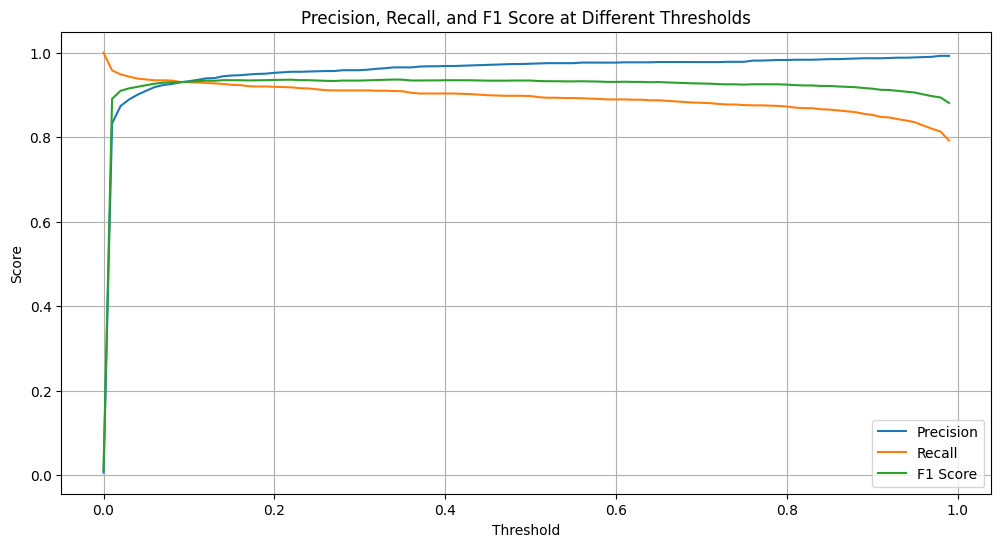

In [56]:
# Evaluate metrics for different thresholds
thresholds = np.arange(0.0, 1.0, 0.01)
metrics = np.array([evaluate_threshold(t) for t in thresholds])

# Extract precision, recall, and f1 score for plotting
precisions = metrics[:, 0]
recalls = metrics[:, 1]
f1_scores = metrics[:, 2]

# Plot the metrics
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Choose the best threshold (example: maximize F1 Score)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Best Threshold: {best_threshold}')

Best Threshold: 0.34


In [59]:
# Choose the best threshold (example: maximize precision Score)
best_threshold_2 = thresholds[np.argmax(precisions)]
print(f'Best Threshold: {best_threshold_2}')

Best Threshold: 0.98


In [62]:
##### Best Threshold: 0.34

# Predict with the best threshold
y_pred_best_threshold = (y_test_proba >= best_threshold).astype(int)

# Print evaluation metrics for the best threshold
precision = precision_score(y_test, y_pred_best_threshold)
recall = recall_score(y_test, y_pred_best_threshold)
f1 = f1_score(y_test, y_pred_best_threshold)
cm = confusion_matrix(y_test, y_pred_best_threshold)
report = classification_report(y_test, y_pred_best_threshold)

print("\nEvaluation Metrics for Best Threshold:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


Evaluation Metrics for Best Threshold:
Precision: 0.9653465346534653
Recall: 0.9093937375083277
F1 Score: 0.9365351629502573

Confusion Matrix:
[[257785     49]
 [   136   1365]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.97      0.91      0.94      1501

    accuracy                           1.00    259335
   macro avg       0.98      0.95      0.97    259335
weighted avg       1.00      1.00      1.00    259335



In [63]:
##### Best Threshold: 0.98

# Predict with the best threshold
y_pred_best_threshold = (y_test_proba >= best_threshold_2).astype(int)

# Print evaluation metrics for the best threshold
precision = precision_score(y_test, y_pred_best_threshold)
recall = recall_score(y_test, y_pred_best_threshold)
f1 = f1_score(y_test, y_pred_best_threshold)
cm = confusion_matrix(y_test, y_pred_best_threshold)
report = classification_report(y_test, y_pred_best_threshold)

print("\nEvaluation Metrics for Best Threshold:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


Evaluation Metrics for Best Threshold:
Precision: 0.9926829268292683
Recall: 0.8134576948700866
F1 Score: 0.8941779567923838

Confusion Matrix:
[[257825      9]
 [   280   1221]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.99      0.81      0.89      1501

    accuracy                           1.00    259335
   macro avg       1.00      0.91      0.95    259335
weighted avg       1.00      1.00      1.00    259335



### Comment:
- In most fraud detection scenarios, recall tends to be slightly more important because the primary goal is to catch as many fraudulent transactions as possible. However, a high false positive rate (low precision) can also be problematic, leading to customer dissatisfaction and operational inefficiencies. Therefore, a balanced approach, often evaluated using the F1 score, is usually preferred.

- However, after consideration, I prefer to optimize precision because this case is not law institutions or diagnosis of disease, and I suppose my bank want to prioritize customer satisfaction. I don't want to inconvenience or cause trouble customers with transactions that aren't actually fraud. False positives (incorrectly flagged legitimate transactions) could lead to customer dissatisfaction.

==> I choose best_threshold of 0.98

# 4. Save the best model

In [ ]:
# best_model = grid_search.best_estimator_

In [ ]:
# best_model = {'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.25, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 3000, 'scale_pos_weight': 1, 'subsample': 0.85}

In [67]:
# Create folder 'models' if it doesn't exist
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

# Save the best model
import joblib
joblib.dump(best_model, '../models/best_model.pkl')

['../models/best_model.pkl']

# 5. Save the best model after adjusting the threshold
Step 1: Adjust the Threshold:

After selecting the best model and threshold, you should adjust the model's decision boundary accordingly. You can do this by creating a wrapper function or modifying the prediction logic.

Step 2: Save the Best Model with Custom Threshold:

Serialize both the model and the custom threshold.

In [68]:
import pickle

# Define a class to wrap the model and threshold
class CustomXGBClassifier:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold

    def predict(self, X):
        probs = self.model.predict_proba(X)[:, 1]  # Get probability for the positive class
        return (probs >= self.threshold).astype(int)  # Apply custom threshold

    def predict_proba(self, X):
        return self.model.predict_proba(X)  # Return raw probabilities

In [71]:
#### Highest Precision

# Create an instance of the custom class
custom_model = CustomXGBClassifier(best_model, best_threshold_2)
custom_model.fit(X_train_subset, y_train)

# Save the custom model with the adjusted threshold
with open('../models/best_model_w_customthreshold_098_highest_precision.pkl', 'wb') as model_file:
    pickle.dump(custom_model, model_file)

AttributeError: 'CustomXGBClassifier' object has no attribute 'fit'

In [70]:
## Highest F1 Score

# Create an instance of the custom class
custom_model = CustomXGBClassifier(best_model, best_threshold)
custom_model.fit(X_train_subset, y_train)

# Save the custom model with the adjusted threshold
with open('../models/best_model_w_customthreshold_034_highest_f1score.pkl', 'wb') as model_file:
    pickle.dump(custom_model, model_file)